<a href="https://colab.research.google.com/github/Zocha1/Introduction-To-Machine-Learning/blob/main/4_PRZYK%C5%81AD_Przetwarzanie_tekstu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Ładowanie zbioru danych

In [21]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


https://keras.io/api/datasets/imdb/

**'num_words=10000'** - użyjemy 10.000 najczęściej występujących słów

**'train_lables' 'test_labels'** - zmienne zawierające etykiety: 0 oznaczających recenzję negatywną i 1 oznaczających recenzję pozytywną



In [22]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [23]:
train_labels[1]

0

In [24]:
len(train_data)

25000

In [25]:
len(test_data)

25000

In [26]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[1]])

print(decoded_review)

? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then


## 2. Przygotowanie danych
Do sieci neuronowej nie można wczytać list liczb całkowitych, trzeba je zamienić na listę **tensorów**. Istnieją dwa sposoby, które nam to umożliwią:
- Należy dopełnić listy, aby wszystkie były jednakowej długości i wtedy zamienić je na **tensor liczb całkowitych** o kształcie: (*próbki, indeksy_słów*). Wtedy pierwszą warstą sieci neuronowej musi być warstwa **Embedding**, która jest w stanie przetwarzać tensory liczb całkowitych.
- **One-hot encoding** - listy można także zamienić na wektory 0 i 1. Na przykład, jeśli twoja sekwencja to [3, 5], a masz słownik o rozmiarze 10 000 słów, to zapiszesz tę sekwencję jako wektor o długości 10 000, gdzie wszystkie elementy są zerami, oprócz indeksów 3 i 5, które są ustawione na 1. Wykorzystując tą metodę pierwszą warstwą sieci może być warstwa Dense, która jest w stanie obsługiwać wektory danych zmiennoprzecinkowych.

Korzystamy z drugiego rozwiązania:

Tworzymy tensor 2D, czyli macierz o wymiarach 25.000 x 10.000 wypełnioną 0 i 1. 25.000, bo tyle mamy recenzji i 10.000, bo tyle jest możliwych słów w recenzjach.
Przykładowo, jeśli recenzja składa się z trzech słów, które w naszym ograniczonym słowniku mają indeksy 5, 8 i 10, wówczas w wierszu odpowiadającym tej recenzji, w kolumnach 5, 8, 10 zostaną umieszczone jedynki, a reszta pozostanie zerami.


In [27]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [28]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Zanim przejdziemy do przetwarzania danych przez sieć neuronową, musimy jeszcze zamienić na wektory etykiety próbek.

In [29]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [30]:
y_train[0]

1.0

Po przetworzeniu danych, etykiety są wartościami skalarnymi - zera i jedynki, dane wejściowe wektorami.

## 3.Budowa sieci neuronowej

Głównym blokiem składowym sieci neuronowej jest **warstwa (layer)**. Można ją traktować jako filtr danych. Dane wychodzące z filtra mają bardziej przydatną formę od danych wchodzących.

Model uczenia głębokiego  jest jak sito przetwarzające dane składające się z coraz drobniejszych siatek-warstw.

Do rozwiązania naszego problemy najlepiej zastosować sieci prostego stosu w pełni połączonych warst - **Dense**:
- dwie pierwsze warsty z aktywacją - **relu**, zawierające 16 ukrytych jednostek (neuronów)
- ostatnia warstwa definijąca przewidywania sentymentu, czy recenzja będzie pozytywna, czy negatywna z funkcją aktywacji - **sigmoid**, która reprezentuje wartości w zakresie od 0 do 1, co pozwalana na określenie prawdopodobieństwa, zawierająca 1 neuron, ponieważ dla klasyfikacji binarnej wynik jest pojedynczą wartością prawdopodobieństwa przynależności do klasy pozytywnej

In [31]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Na tym etapie musimy określić jeszcze 3 rzeczy w celu przygotowania sieci do trenowania:
- **funkcja straty**: sposób pomiaru wydajności sieci podczas przetwarzania treningowego zbioru danych - dostrajanie parametrów sieci we właściwym kierunku
- **optymalizator**: mechanizm dostrajania sieci na podstawie danych zwracanych przez funkcję straty
- **metryki monitorowania podczas trenowania i testowania**: dokładność, czyli część obrazków, która została dobrze sklasyfikowana


- Nasz problem polega na klasyfikacji binarnej, w której sieć zwraca nam wartość prawdopodobieństwa, dlatego najlepszym wyborem funkcji straty będzie binarna entropia krzyżowa - **binary_crossentropy**.
- Dobrym wyborem do więkoszści problemów będzie optymalizator **rmsprop**.
- Metryką do zadań klasyfikacji binarnej jest dokładność - **accuracy**

In [32]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 4. Walidacja modelu


Walidacja modelu jest kluczowym krokiem w procesie budowania i optymalizacji modeli uczenia maszynowego, w tym sieci neuronowych. Jej głównym celem jest ocena, jak dobrze model generalizuje się na nowych, nieznanych danych, które nie były wykorzystywane podczas treningu.

W tym celu utworzymy zbiór danych, które nie były wykorzystane podczas trenowania modelu. Zrobimy to przez oddzielenie 10.000 próbek od treningowego zbioru danych.


In [33]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 5. Trenowanie modelu

Teraz będziemy trenować model przez **20 epok**. To oznacza, że cały zbiór treningowy x_train i odpowiadające mu etykiety y_train zostaną przepuszczone przez model 20 razy, co pozwala na dokładniejsze dostosowanie wag modelu do przetwarzanych danych.

Z podziałem na **wsady po 512 próbek**. Oznacza to, że zamiast aktualizować wagi modelu po każdej próbce (co jest nieefektywne) lub po całym zestawie danych (co może wymagać dużo pamięci i być wolne), aktualizacje wag są przeprowadzane po każdych 512 próbkach. To ułatwia efektywniejsze i szybsze treningi.

Jednocześnie będziemy monitorować funkcje straty i dokładność modelu przy przetwarzaniu 10.000 próbek, które przed chwilą wyodrębniliśmy. W tym celu musimy przekazać zbiór walidacyjny (kontrolny) jako argument validation_data.
Pod koniec trwania każdej epoki algorytm zatrzymuje się na chwilę, ponieważ model oblicza stratę i dokładność, korzystając z 10.000 próbek walidacyjnego zbioru danych.



In [34]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 80ms/step - loss: 0.5377 - accuracy: 0.7709 - val_loss: 0.4314 - val_accuracy: 0.8275
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.3334 - accuracy: 0.8909 - val_loss: 0.3320 - val_accuracy: 0.8728
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2439 - accuracy: 0.9182 - val_loss: 0.2859 - val_accuracy: 0.8884
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1933 - accuracy: 0.9361 - val_loss: 0.2848 - val_accuracy: 0.8845
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1613 - accuracy: 0.9478 - val_loss: 0.2793 - val_accuracy: 0.8876
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1338 - accuracy: 0.9582 - val_loss: 0.2965 - val_accuracy: 0.8811
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1149 - accuracy: 0.9640 - val_loss: 0.3250 - val_accuracy: 0.8795
Epoch 8/20
30

Wywołanie metody **model.fit()** zwraca obiekte **History**, zawierający element **history** - słownik danych dotyczących przebiegu trenowania.

In [35]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Ocena wydajności już wytrenowanego modelu na zestawie danych testowych, pozwala na sprawdzenie, jak dobrze model generalizuje się na nowych, niewidzianych wcześniej danych.

In [36]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.6137 - accuracy: 0.8590


## 6. Interpretacja wyników przewidywań

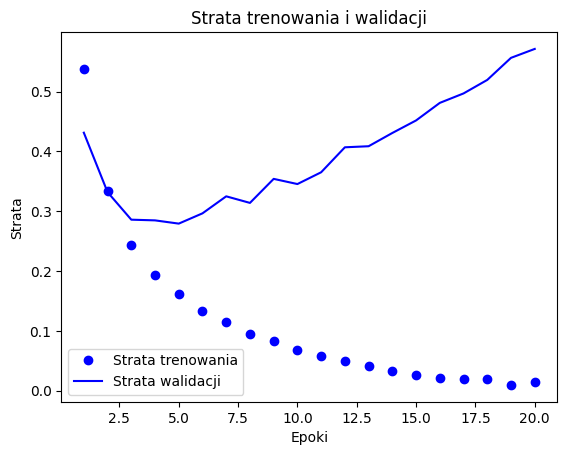

In [37]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss_values, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

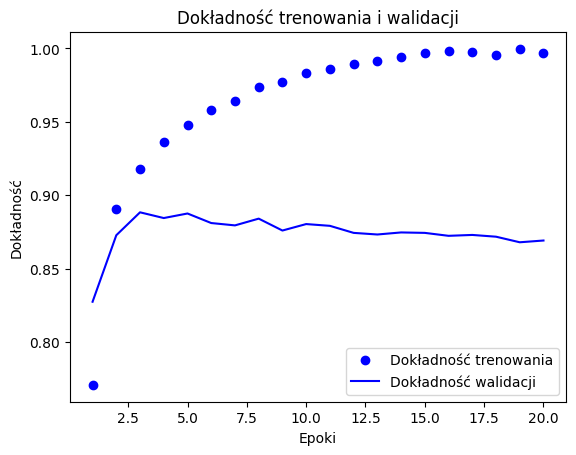

In [39]:
plt.clf()

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc_values, 'b', label='Dokładność walidacji')
plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.show()